In [8]:
import numpy as np
import scipy.sparse as sp
from scipy.sparse.linalg import eigsh
from itertools import combinations_with_replacement, permutations
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from qutip import *

In [12]:
Nph = 3
a = tensor(qeye(2), qeye(2), destroy(Nph))

sm1 = tensor( sigmam(), qeye(2), qeye(Nph) )
sm2 = tensor( qeye(2), sigmam(), qeye(Nph) )

sx1 = tensor( sigmax(), qeye(2), qeye(Nph) )
sx2 = tensor( qeye(2), sigmax(), qeye(Nph) )

sy1 = tensor( sigmay(), qeye(2), qeye(Nph) )
sy2 = tensor( qeye(2), sigmay(), qeye(Nph) )

sz1 = tensor( sigmaz(), qeye(2), qeye(Nph) )
sz2 = tensor( qeye(2), sigmaz(), qeye(Nph) )

id_op = tensor( qeye(2), qeye(2), qeye(Nph))


evals, evecs = (1.3*sz1+sz2 + 10*a.dag()*a).eigenstates()
Psi_00 = evecs[0]
Psi_01 = evecs[1]
Psi_10 = evecs[2]
Psi_11 = evecs[3]

rho0 = Psi_00 * Psi_00.dag()


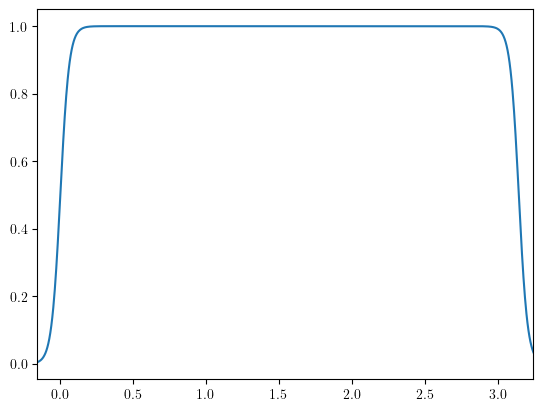

In [13]:
#Visualize the shape of the two pulses we are going to perform
f = lambda t, t0, t1, tau: 1 / (np.exp(-(t - t0) / tau) + 1) * (1 / (np.exp((t - t1) / tau) + 1))
times = np.linspace(-np.pi/20, np.pi+.1, 1000)
plt.plot(times, f(times, 0, np.pi, 0.03))


In [123]:
#Perform the time evolutioon of the physical system under the two subsequent pulses
om0 = 10
Delta = 20
delta = .001
T = 1.
n_th_q = 0      #To show the main feat of MS gate we set always to zero the temperature for the qubit
n_th_a = 1./( np.exp(Delta/T) - 1. )    #while we keep a finite T temp for the Bosonic bus
gamma1 = .01
gamma2 = gamma1
gamma_a = .01

g = 1

t0 = 0
t1 = np.pi/8 * ( Delta**2 - delta**2 )/(g**2*Delta)
tau = .1

c_jumps = [ np.sqrt(gamma1*(1+n_th_q))*sm1, np.sqrt(gamma1*(n_th_q))*sm1.dag(), np.sqrt(gamma2*(1+n_th_q))*sm2, np.sqrt(gamma2*(n_th_q))*sm2.dag(), np.sqrt(gamma_a*(1+n_th_a))*a, np.sqrt(gamma_a*(n_th_a))*a.dag()  ]

H0 = delta * ( sz1 + sz2 ) + Delta * a.dag()*a

H1 = g * (a + a.dag()) * (sx1 + sx2)

args =  {'t0': t0, 't1': t1, 'tau': tau}

H = [H0, [ H1 , lambda t : 1 / (np.exp(-(t - args['t0']) / args['tau']) + 1) * (1 / (np.exp((t - args['t1']) / args['tau']) + 1)) ] ]

times = np.linspace(-np.pi/20, t1+.1, 1000)

output = mesolve(H, rho0, times, c_jumps, e_ops=[], args=args)

(0.0, 1.0)

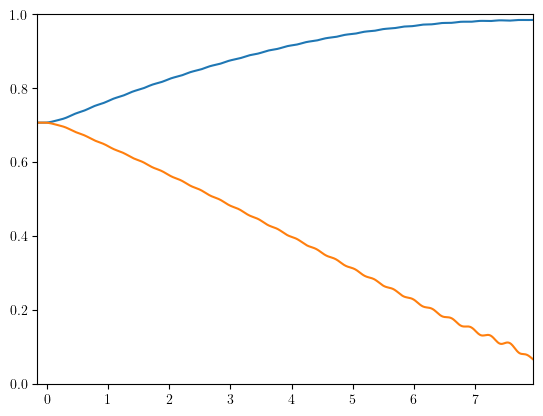

In [124]:
rhot = output.states
TG_state = .5**.5 * ( id_op + 1j*sx1*sx2 ) * Psi_00
rho_TG = TG_state * TG_state.dag()


arr_fid = np.zeros( len(times) )
arr_dist = np.zeros( len(times) )
for nt, t in enumerate(times):
    arr_fid[nt] = np.abs( fidelity( rho_TG, rhot[nt] ) )
    arr_dist[nt] = np.abs( tracedist(rho_TG, rhot[nt]) )
    
plt.plot(times, arr_fid)
plt.plot(times, arr_dist)
plt.ylim(0,1)

In [135]:
#Repeat the previous algorithm for several values of the temperature T and see how the fidelity (or trace distant) of the output state is destroyed


#vT = np.linspace(.01, 10, 30)
vT = np.logspace(-2, 3, 30)
arr_fid_T = np.zeros(len(vT))
arr_dist_T = np.zeros(len(vT))

for indxT, T in enumerate(vT):
    om0 = 1
    Delta = 10
    delta = .001
    n_th_q = 0
    n_th_a = 1./( np.exp(Delta/T) - 1. )
    gamma1 = .001
    gamma2 = gamma1
    gamma_a = .01

    g = 1

    t0 = 0
    t1 = np.pi/8 * ( Delta**2 - delta**2 )/(g**2*Delta)
    tau = .1

    c_jumps = [ np.sqrt(gamma1*(1+n_th_q))*sm1, np.sqrt(gamma1*(n_th_q))*sm1.dag(), np.sqrt(gamma2*(1+n_th_q))*sm2, np.sqrt(gamma2*(n_th_q))*sm2.dag(), np.sqrt(gamma_a*(1+n_th_a))*a, np.sqrt(gamma_a*(n_th_a))*a.dag()  ]

    H0 = delta * ( sz1 + sz2 ) + Delta * a.dag()*a

    H1 = g * (a + a.dag()) * (sx1 + sx2)

    args =  {'t0': t0, 't1': t1, 'tau': tau}

    H = [H0, [ H1 , lambda t : 1 / (np.exp(-(t - args['t0']) / args['tau']) + 1) * (1 / (np.exp((t - args['t1']) / args['tau']) + 1)) ] ]

    times = np.linspace(-np.pi/20, t1+.1, 1000)

    output = mesolve(H, rho0, times, c_jumps, e_ops=[], args=args)
    rhot = output.states
    rho_out = rhot[len(times)-1]
    arr_fid_T[indxT] = np.abs( fidelity( rho_TG, rho_out ) )
    arr_dist_T[indxT] = np.abs( 1-tracedist( rho_TG, rho_out ) )
    

/var/folders/y4/dpq6l9fj2kv9z0prq_6_pyy00000gn/T/ipykernel_34169/1670275511.py:14: RuntimeWarning: overflow encountered in exp
  n_th_a = 1./( np.exp(Delta/T) - 1. )


(0.0, 1.0)

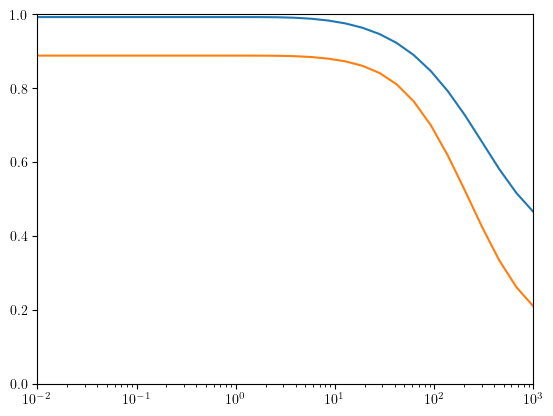

In [136]:
plt.plot(vT, arr_fid_T)
plt.plot(vT, arr_dist_T)
plt.xscale('log')
plt.ylim(0,1)